In [1]:
from collections import namedtuple, OrderedDict
import itertools
import os
import numpy as np
from typing import Tuple
from typing import List
from typing import Dict
import random
from itertools import product
import copy
import re
import random

from utils import one_hot
from utils import generate_possible_object_names
from utils import numpy_array_to_image

from vocabulary import *
from object_vocabulary import *
from world import *
from grammer import *
from simulator import *
from relation_graph import *

from networkx.algorithms import isomorphism
from networkx import DiGraph
from networkx import line_graph

# from generate_ReaSCAN import *

### Vocabulary Module

In [2]:
# test out the vocabulary
intransitive_verbs = ["walk"]
transitive_verbs = ["push", "pull"]
adverbs = ["while zigzagging", "while spinning", "cautiously", "hesitantly"]
nouns = ["circle", "cylinder", "square", "box"]
color_adjectives = ["red", "blue", "green", "yellow"]
size_adjectives = ["big", "small"]
relative_pronouns = ["that is"]
relation_clauses = ["in the same row as", 
                    "in the same column as", 
                    "in the same color as", 
                    "in the same shape as", 
                    "in the same size as",
                    "inside of"]
vocabulary = Vocabulary.initialize(intransitive_verbs=intransitive_verbs,
                                   transitive_verbs=transitive_verbs, adverbs=adverbs, nouns=nouns,
                                   color_adjectives=color_adjectives,
                                   size_adjectives=size_adjectives, 
                                   relative_pronouns=relative_pronouns, 
                                   relation_clauses=relation_clauses)

In [3]:
# test out the object vocab
min_object_size = 1
max_object_size = 4
object_vocabulary = ObjectVocabulary(shapes=vocabulary.get_semantic_shapes(),
                                     colors=vocabulary.get_semantic_colors(),
                                     min_size=min_object_size, max_size=max_object_size)
# object_vocabulary.generate_objects()

### Situtation Module

In [4]:
# test out situation repr
TEST_SITUATION_1 = Situation(grid_size=15, agent_position=Position(row=7, column=2), agent_direction=INT_TO_DIR[0],
                             target_object=PositionedObject(object=Object(size=2, color='red', shape='circle'),
                                                            position=Position(row=10, column=4),
                                                            vector=np.array([1, 0, 1])),
                             placed_objects=[PositionedObject(object=Object(size=2, color='red', shape='circle'),
                                                              position=Position(row=10, column=4),
                                                              vector=np.array([1, 0, 1])),
                                             PositionedObject(object=Object(size=4, color='green', shape='circle'),
                                                              position=Position(row=3, column=12),
                                                              vector=np.array([0, 1, 0]))], carrying=None)
# TEST_SITUATION_1.to_representation()

In [5]:
# test out our new object definition
PositionedObject(object=Object(size=4, color='green', shape='box'),
                 position=Position(row=3, column=12),
                 vector=np.array([0, 1, 0]), overflow=True, overlap=True)

PositionedObject(object=Object(size=4, color='green', shape='box'), position=Position(column=12, row=3), vector=array([0, 1, 0]), overflow=True, overlap=True)

### Grammer

In [6]:
# Generating all the core command structs.
grammer = Grammer(vocabulary)

### World Module with Mini-Gym

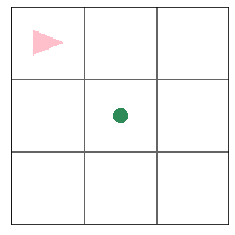

False

In [7]:
# test out the world
import matplotlib as plt
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import os
os.environ['QT_QPA_PLATFORM']='offscreen'

world = World(grid_size=3, colors=vocabulary.get_semantic_colors(),
              object_vocabulary=object_vocabulary,
              shapes=vocabulary.get_semantic_shapes(),
              save_directory="./tmp/")

world.place_object(Object(size=1, color="green", shape="circle"), position=Position(row=1, column=1))
# world.place_object(Object(size=2, color="red", shape="box"), position=Position(row=0, column=0))
_ = world.render_simple()
world.position_taken(position=Position(row=0, column=0), condition="box")


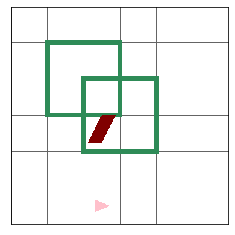

In [8]:
world = World(grid_size=6, colors=vocabulary.get_semantic_colors(),
              object_vocabulary=object_vocabulary,
              shapes=vocabulary.get_semantic_shapes(),
              save_directory="./tmp/")

# try to place an object on to the map
world.clear_situation()
# world.place_object(Object(size=4, color="green", shape="box"), position=Position(row=3, column=3))
world.place_object(Object(size=2, color="green", shape="box"), position=Position(row=2, column=2))
world.place_object(Object(size=2, color="green", shape="box"), position=Position(row=1, column=1))
world.place_object(Object(size=3, color="red", shape="cylinder"), position=Position(row=3, column=2))
world.place_agent_at(Position(row=5, column=2))

_ = world.render_simple()

verb = "push"
adverb = "cautiously"

# Direct walk.
action = "walk" # this is definit!
primitive_command = vocabulary.translate_word(action)
target_position = Position(row=3, column=2)
# simulator._world.get_current_situation().to_dict()["target_object"].position
world.go_to_position(position=target_position, manner=adverb, primitive_command=primitive_command)

# Object actions.
if True:
    semantic_action = vocabulary.translate_word(verb)
    world.move_object_to_wall(action=semantic_action, manner=adverb)
target_commands, target_demonstration = world.get_current_observations()

In [9]:
_ = world.render_simple()

In [10]:
world.grid.get(2,0).vector_representation

array([0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0])

### ReaSCAN Off-the-shelve Reading

In [ ]:
# we can take the json example and loaded as the world. 
# then you can manipulate it as if it were generated 
# from the engine.
# TODO

# Read-in info.
path_to_data = "../../../data-files/ReaSCAN-Simple/data-compositional-splits.txt"
ReaSCAN_data_json = json.load(open(path_to_data, "r"))

In [ ]:
example = ReaSCAN_data_json["examples"]["train"][random.randint(0, len(ReaSCAN_data_json["examples"]["train"])-1)]
command = example["command"]
print(f"command: {command}")
situation = example["situation"]
world = World(grid_size=6, colors=vocabulary.get_semantic_colors(),
              object_vocabulary=object_vocabulary,
              shapes=vocabulary.get_semantic_shapes(),
              save_directory="./tmp/")
world.clear_situation()
for obj_idx, obj in situation["placed_objects"].items():
    world.place_object(
        Object(size=int(obj["object"]["size"]), color=obj["object"]["color"], shape=obj["object"]["shape"]), 
        position=Position(row=int(obj["position"]["row"]), column=int(obj["position"]["column"]))
    )
world.place_agent_at(
    Position(
        row=int(situation["agent_position"]["row"]), 
        column=int(situation["agent_position"]["column"])
))
_ = world.render_simple()

# HERE: you can change to other target object.
target_position = Position(
    row=int(situation['target_object']['position']["row"]), 
    column=int(situation['target_object']['position']["column"])
)
world.go_to_position(position=target_position, manner='', primitive_command="walk")
target_commands, target_demonstration = world.get_current_observations()
print(f"action: {target_commands}")

### ReaSCAN Grammer Module

In [ ]:
command_structs = []
grammer = Grammer(vocabulary)
exhaustive_verb_adverb = True
# patterns = grammer._sample_grammer_pattern_reascan_train()
patterns = ['$OBJ_0']
for grammer_pattern in patterns:
    print(grammer_pattern)
    relations = grammer.sample_object_relation_grammer(
    '$OBJ_0', 
    grammer.build_dependency_graph(grammer_pattern))
    for relation in relations:
        obj_pattern_map = relation[0]
        rel_map = relation[1]
        grammer_bindings = grammer.grounding_grammer_with_vocabulary(grammer_pattern, obj_pattern_map, rel_map)
        for obj_map in grammer_bindings:
            # here, we also sample the verb and adverb bindings!
            if exhaustive_verb_adverb:
                for adverb in vocabulary.get_adverbs() + [""]:
                    for verb in vocabulary.get_transitive_verbs() + vocabulary.get_intransitive_verbs():
                        command_struct = {
                            "obj_pattern_map" : obj_pattern_map,
                            "rel_map" : rel_map,
                            "obj_map" : obj_map,
                            "grammer_pattern" : grammer_pattern,
                            "adverb" : adverb,
                            "verb" : verb,
                        }
                        command_structs += [command_struct]
            else:
                command_struct = {
                    "obj_pattern_map" : obj_pattern_map,
                    "rel_map" : rel_map,
                    "obj_map" : obj_map,
                    "grammer_pattern" : grammer_pattern,
                    "adverb" : random.choice(vocabulary.get_adverbs()),
                    "verb" : random.choice(vocabulary.get_transitive_verbs() + vocabulary.get_intransitive_verbs()),
                }
                command_structs += [command_struct]

In [ ]:
def get_command_struct_statistics(
    command_structs, run_name="ReaSCAN-Awesome", date="2021-05-06", 
    split="demo",
    compositional_split=False,
    n_sample=-1, n_runs=10,
    output_dir="../../data-files/ReaSCAN-compositional_splits/",
    save_to_disk=True,
    wandb=None
):
    statistics = OrderedDict({
        "run_name": run_name,
        "date": date,
        "splits": split,
        "number_of_these_examples_seen_in_training": -1 if not compositional_split else 0,
        "number_of_command_structs": len(command_structs),
    })
    if n_sample == -1:
        n_sample = len(command_structs)
    # If we are downsampling, we need to do more runs as well!
    random.shuffle(command_structs)
    
    patterns = set([])
    for command_s in command_structs:
        patterns.add(command_s["grammer_pattern"])
    statistics["command_patterns"] = list(patterns)
    
    pattern_stats = get_keyword_statistics(command_structs, include_keyword="grammer_pattern")
    statistics["pattern_stats"] = pattern_stats
    
    # verb
    verb_stats = get_keyword_statistics(command_structs, include_keyword="verb")
    statistics["verb_stats"] = verb_stats
    plot_dictionary(
        [verb_stats],
        title="Verbs",
        save_file=os.path.join(output_dir, f"verb_stats-{split}.png"),
        wandb=wandb,
    )
    
    # adverb
    adverb_stats = get_keyword_statistics(command_structs, include_keyword="adverb")
    # special handling for adverb for better readabilities
    adverb_stats_rebuild = {}
    for k, v in adverb_stats.items():
        if k == "":
            adverb_stats_rebuild["EMPTY"] = v
        else:
            adverb_stats_rebuild[k] = v
    statistics["adverb_stats"] = adverb_stats_rebuild
    plot_dictionary(
        [adverb_stats_rebuild],
        title="Adverbs",
        save_file=os.path.join(output_dir, f"adverb_stats-{split}.png"),
        wandb=wandb,
    )
    
    # relation
    relation_stats = get_relation_statistics(command_structs)
    if len(relation_stats) != 0:
        statistics["relation_stats"] = relation_stats
        plot_dictionary(
            [flatten_dictionary(relation_stats)],
            title="Relation-Types",
            save_file=os.path.join(output_dir, f"relation_type_stats-{split}.png"),
            wandb=wandb,
        )
    
    # attribute
    nouns = ["circle", "cylinder", "square", "box", "object"]
    n_stats = get_attribute_statistics(command_structs, include_keywords=nouns)
    statistics["shape_stats"] = n_stats
    plot_dictionary(
        [flatten_dictionary(n_stats)],
        title="Shapes",
        save_file=os.path.join(output_dir, f"shape_stats-{split}.png"),
        wandb=wandb,
    )
    
    color_adjectives = ["red", "blue", "green", "yellow"]
    c_stats = get_attribute_statistics(command_structs, include_keywords=color_adjectives)
    statistics["color_stats"] = c_stats
    plot_dictionary(
        [flatten_dictionary(c_stats)],
        title="Colors",
        save_file=os.path.join(output_dir, f"color_stats-{split}.png"),
        wandb=wandb,
    )

    size_adjectives = ["big", "small"]
    s_stats = get_attribute_statistics(command_structs, include_keywords=size_adjectives)
    statistics["size_stats"] = s_stats
    plot_dictionary(
        [flatten_dictionary(s_stats)],
        title="Sizes",
        save_file=os.path.join(output_dir, f"size_stats-{split}.png"),
        wandb=wandb,
    )
    
    # second order attribute
    color_adjectives = ["red", "blue", "green", "yellow"]
    nouns = ["circle", "cylinder", "square", "box", "object"]
    c_n_p = product(color_adjectives, nouns)
    include_keywords = [" ".join(c_n) for c_n in c_n_p]
    c_n_stats = get_attribute_statistics(command_structs, include_keywords=include_keywords)
    statistics["color_and_shape_stats"] = c_n_stats
    plot_dictionary(
        [flatten_dictionary(c_n_stats)],
        title="Colors-Shapes",
        save_file=os.path.join(output_dir, f"color+shape_stats-{split}.png"),
        wandb=wandb,
    )

    size_adjectives = ["big", "small"]
    nouns = ["circle", "cylinder", "square", "box", "object"]
    s_n_p = product(size_adjectives, nouns)
    include_keywords = [" ".join(s_n) for s_n in s_n_p]
    s_n_stats = get_attribute_statistics(command_structs, include_keywords=include_keywords)
    statistics["size_and_shape_stats"] = s_n_stats
    plot_dictionary(
        [flatten_dictionary(s_n_stats)],
        title="Sizes-Shapes",
        save_file=os.path.join(output_dir, f"size+shape_stats-{split}.png"),
        wandb=wandb,
    )
    
    # third order attribute
    size_adjectives = ["big", "small"]
    color_adjectives = ["red", "blue", "green", "yellow"]
    nouns = ["circle", "cylinder", "square", "box", "object"]
    all_p = product(size_adjectives, color_adjectives, nouns)
    include_keywords = [" ".join(a) for a in all_p]
    all_stats = get_attribute_statistics(command_structs, include_keywords=include_keywords)
    statistics["size_and_color_and_shape_stats"] = all_stats
    
    if save_to_disk:
        import yaml
        with open(os.path.join(output_dir, f"command_struct_only_stats-{split}.yml"), 'w') as yaml_file:
            yaml.dump(statistics, yaml_file, default_flow_style=False)
    
    return statistics

In [ ]:
get_command_struct_statistics(
    command_structs, run_name="ReaSCAN-Awesome", date="2021-05-16", 
    split="demo",
    compositional_split=False,
    n_sample=-1, n_runs=10,
    output_dir="../../data-files/ReaSCAN-demo/",
    save_to_disk=True,
    wandb=None
)

### ReaSCAN Simulator

In [ ]:
simulator = Simulator(
    object_vocabulary, vocabulary, 
    grid_size=6, 
    n_object_max=10,
)

In [ ]:
obj_pattern_map = {'$OBJ_0': '$ABS_SHAPE', '$OBJ_1': '$SHAPE', '$OBJ_2': '$SHAPE'}
rel_map = {('$OBJ_0', '$OBJ_1'): '$SAME_SHAPE', ('$OBJ_0', '$OBJ_2'): '$IS_INSIDE'}
obj_map = {'$OBJ_0': 'object', '$OBJ_1': 'circle', '$OBJ_2': 'box'}
grammer_pattern = '$OBJ_0 ^ $OBJ_1 & $OBJ_2'
verb = "push"
adverb = "slowly"
sampled_world = simulator.sample_situations_from_grounded_grammer(
    copy.deepcopy(grammer_pattern), 
    copy.deepcopy(obj_pattern_map), 
    copy.deepcopy(rel_map), 
    copy.deepcopy(obj_map),
    is_plot=True,
    include_relation_distractor=False, 
    include_attribute_distractor=False, 
    include_isomorphism_distractor=False, 
    include_random_distractor=False,
    full_relation_probability=0.5,
    debug=False
)

In [ ]:
is_transitive = False
if verb in simulator.vocabulary.get_transitive_verbs():
    is_transitive = True

# Direct walk.
action = "walk" # this is definit!
primitive_command = simulator.vocabulary.translate_word(action)
target_position = sampled_world["situation"].target_object.position

simulator._world.go_to_position(position=target_position, manner=adverb, primitive_command=primitive_command)

# Object actions.
if is_transitive:
    semantic_action = simulator.vocabulary.translate_word(verb)
    simulator._world.move_object_to_wall(action=semantic_action, manner=adverb)
target_commands, target_demonstration = simulator._world.get_current_observations()

In [ ]:
target_commands

### End-to-end Task Generation

In [ ]:
# Simulator robustness tests.
random.shuffle(command_structs)
simulator = Simulator(
    object_vocabulary, vocabulary, 
    grid_size=6, 
    n_object_max=10,
)
count = 0
special_count = 0
minor_count = 0
for test_struct in command_structs[:10000]:
    count += 1
    if count%1000==0:
        print(f"passing rate = {count}/{10000}")
    obj_pattern_map = test_struct["obj_pattern_map"]
    rel_map = test_struct["rel_map"]
    obj_map = test_struct["obj_map"]
    grammer_pattern = test_struct["grammer_pattern"]
    verb = test_struct["verb"]
    adverb = test_struct["adverb"]

    test_unique_find = 0
    for i in range(20):
        minor_count += 1
        sampled_world = simulator.sample_situations_from_grounded_grammer(
            copy.deepcopy(grammer_pattern), 
            copy.deepcopy(obj_pattern_map), 
            copy.deepcopy(rel_map), 
            copy.deepcopy(obj_map),
            is_plot=False,
            include_relation_distractor=True, 
            include_attribute_distractor=True, 
            include_isomorphism_distractor=False, 
            include_random_distractor=True,
            full_relation_probability=0.5, # 0.5 seems to work as well!
            debug=False
        )
#         if len(sampled_world["distractor_switch_map"]['relation']) == 2 and \
#             sampled_world["distractor_switch_map"]['relation'][0] == True and \
#             sampled_world["distractor_switch_map"]['relation'][0] == True:
#             special_count += 1
#             print(f"{special_count}/{minor_count}")
        assert len(sampled_world['obj_map']) == len(simulator._world.get_current_situation().to_representation()["placed_objects"])


In [17]:
grammer_pattern = '$OBJ_0 ^ $OBJ_1 & $OBJ_2'
command_structs = []
# Sampling relations
relations = grammer.sample_object_relation_grammer(
    '$OBJ_0', 
    grammer.build_dependency_graph(grammer_pattern))
for relation in relations:
    obj_pattern_map = relation[0]
    rel_map = relation[1]
    grammer_bindings = grammer.grounding_grammer_with_vocabulary(grammer_pattern, obj_pattern_map, rel_map)
    for obj_map in grammer_bindings:
        # here, we also sample the verb and adverb bindings!
        adverb_enhance_list = vocabulary.get_adverbs()
        adverb_enhance_list += [""]
        command_struct = {
            "obj_pattern_map" : obj_pattern_map,
            "rel_map" : rel_map,
            "obj_map" : obj_map,
            "grammer_pattern" : grammer_pattern,
            "adverb" : random.choice(adverb_enhance_list),
            "verb" : random.choice(vocabulary.get_transitive_verbs() + vocabulary.get_intransitive_verbs()),
        }
        command_structs += [command_struct]

In [18]:
command_structs[0]

{'obj_pattern_map': {'$OBJ_0': '$SHAPE',
  '$OBJ_1': '$COLOR $SHAPE',
  '$OBJ_2': '$COLOR $SHAPE'},
 'rel_map': OrderedDict([(('$OBJ_0', '$OBJ_1'), '$SAME_ROW'),
              (('$OBJ_0', '$OBJ_2'), '$SAME_COLUMN')]),
 'obj_map': {'$OBJ_0': 'circle',
  '$OBJ_1': 'red cylinder',
  '$OBJ_2': 'red square'},
 'grammer_pattern': '$OBJ_0 ^ $OBJ_1 & $OBJ_2',
 'adverb': 'while zigzagging',
 'verb': 'walk'}

1 / 6 unique solution find!
push the circle that is in the same row as a red square that is inside of a red box while spinning
['turn left', 'turn left', 'turn left', 'turn left', 'turn left', 'turn left', 'walk', 'turn left', 'turn left', 'turn left', 'turn left', 'turn left', 'walk', 'turn left', 'turn left', 'turn left', 'turn left', 'push', 'turn left', 'turn left', 'turn left', 'turn left', 'push']
{'obj_map': OrderedDict([('$OBJ_0', Object(size=1, color='yellow', shape='circle')), ('$OBJ_1', Object(size=3, color='red', shape='square')), ('$OBJ_2', Object(size=1, color='red', shape='box')), ('$OBJ_3', Object(size=2, color='yellow', shape='circle')), ('$OBJ_4', Object(size=3, color='red', shape='square')), ('$OBJ_5', Object(size=4, color='blue', shape='circle')), ('$OBJ_6', Object(size=2, color='red', shape='cylinder')), ('$OBJ_7', Object(size=4, color='red', shape='box')), ('$OBJ_8', Object(size=4, color='red', shape='cylinder')), ('$OBJ_9', Object(size=4, color='red', shape='circ

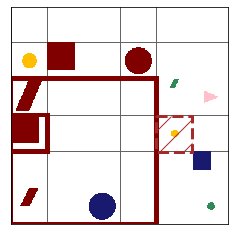

In [35]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
plt.rcParams["font.family"] = "DejaVu Serif"
font = {'family' : 'DejaVu Serif'}
plt.rc('font', **font)

example_count = 0
metadata_json = OrderedDict({})
all_metadata = []

# P1
# test_struct = {'obj_pattern_map': {'$OBJ_0': '$SHAPE'},
#  'rel_map': OrderedDict({}),
#  'obj_map': {'$OBJ_0': 'cylinder'},
#  'grammer_pattern': '$OBJ_0',
#  'adverb': 'cautiously',
#  'verb': 'pull'}

# P2
# test_struct = {'obj_pattern_map': {'$OBJ_0': '$SIZE $SHAPE', 
#                                    '$OBJ_1': '$COLOR $SHAPE'},
#  'rel_map': OrderedDict({(('$OBJ_0', '$OBJ_1'), '$SAME_ROW')}),
#  'obj_map': {'$OBJ_0': 'small square', 
#              '$OBJ_1': 'yellow cylinder'},
#  'grammer_pattern': '$OBJ_0 ^ $OBJ_1',
#  'adverb': 'hesitantly',
#  'verb': 'push'}

# P3
# test_struct = {'obj_pattern_map': {'$OBJ_0': '$SHAPE',
#   '$OBJ_1': '$COLOR $SHAPE',
#   '$OBJ_2': '$SIZE $COLOR $SHAPE'},
#  'rel_map': OrderedDict([(('$OBJ_0', '$OBJ_1'), '$SAME_COLUMN'),
#               (('$OBJ_0', '$OBJ_2'), '$SAME_ROW')]),
#  'obj_map': {'$OBJ_0': 'square',
#   '$OBJ_1': 'blue cylinder',
#   '$OBJ_2': 'small red circle'},
#  'grammer_pattern': '$OBJ_0 ^ $OBJ_1 & $OBJ_2',
#  'adverb': 'while spinning',
#  'verb': 'walk'}

# Test
test_struct = OrderedDict([('obj_pattern_map',
    {'$OBJ_0': '$SHAPE',
    '$OBJ_1': '$COLOR $SHAPE',
    '$OBJ_2': '$COLOR $SHAPE'}),
    ('rel_map',
    OrderedDict([(('$OBJ_0', '$OBJ_1'), '$SAME_ROW'),
               (('$OBJ_1', '$OBJ_2'), '$IS_INSIDE')])),
    ('obj_map',
    {'$OBJ_0': 'circle',
    '$OBJ_1': 'red square',
    '$OBJ_2': 'red box'}),
    ('grammer_pattern', '$OBJ_0 ^ $OBJ_1 ^ $OBJ_2'),
    ('adverb', 'while spinning'),
    ('verb', 'push')]
)

simulator = Simulator(
    object_vocabulary, vocabulary, 
    grid_size=6, 
    n_object_max=13,
)
grammer = Grammer(vocabulary)

obj_pattern_map = test_struct["obj_pattern_map"]
rel_map = test_struct["rel_map"]
obj_map = test_struct["obj_map"]
grammer_pattern = test_struct["grammer_pattern"]
verb = test_struct["verb"]
adverb = test_struct["adverb"]

test_unique_find = 0
for i in range(1000):
    sampled_world = simulator.sample_situations_from_grounded_grammer(
            copy.deepcopy(grammer_pattern), 
            copy.deepcopy(obj_pattern_map), 
            copy.deepcopy(rel_map), 
            copy.deepcopy(obj_map),
            is_plot=False,
            include_relation_distractor=True, 
            include_attribute_distractor=True, 
            include_isomorphism_distractor=True, 
            include_random_distractor=True,
            full_relation_probability=1.0, # 0.5 seems to work as well!
            debug=False
        )

    # _ = simulator._world.render_simple()
    
    assert len(sampled_world['obj_map']) == len(simulator._world.get_current_situation().to_representation()["placed_objects"])
    
    graph = ReaSCANGraph(
        objects=sampled_world["obj_map"], 
        object_patterns=sampled_world["obj_pattern_map"], 
        vocabulary=vocabulary,
        positions=sampled_world["pos_map"], 
        referred_object=sampled_world["referred_obj"],
        debug=False
    )
    
    # graph.draw()
    
    pattern_graph = ReaSCANGraph(
        objects=obj_map, 
        object_patterns=None,
        vocabulary=vocabulary,
        relations=rel_map, 
        referred_object='$OBJ_0', 
        debug=False
    )
    
    # pattern_graph.draw()
    
    potential_referent_target = graph.find_referred_object_super_fast(
        pattern_graph, referred_object='$OBJ_0', 
        pattern="$OBJ_0 ^ $OBJ_1 ^ $OBJ_2",
        debug=False
    )
    
    # Form the command with grounded determiners!
    obj_determiner_map = graph.find_determiners(
        pattern_graph, 
        referred_object='$OBJ_0', 
        debug=False,
    )
    command_str = grammer.repre_str_command(
        grammer_pattern, rel_map, obj_map, 
        obj_determiner_map, 
        verb,
        adverb,
    )
    
    if len(potential_referent_target) == 1 and "$OBJ_0" in potential_referent_target:
        test_unique_find += 1
        print(f"{test_unique_find} / {i+1} unique solution find!")
        
        # graph.draw(save_file="../../data-files-updated/Analysis-Result/graph-example.png")
        # pattern_graph.draw(save_file="../../data-files-updated/Analysis-Result/subgraph-example.png")
        world_array = simulator._world.render_simple(array_only=True)
        fig = plt.figure()
        ax = fig.add_subplot(111)
        ax.imshow(world_array)
        for p_obj in list(potential_referent_target):
            obj = sampled_world['pos_map'][p_obj]
            row = int(obj.row)
            col = int(obj.column)

            ax.add_patch(
                patches.Rectangle(
                    xy=(col*60, row*60),  # point of origin.
                    width=60,
                    height=60,
                    linewidth=3,
                    color='brown',
                    fill=False,
                    alpha=1,
                    hatch="/",
                    linestyle="--"
                )
            )
        plt.xticks([])
        plt.yticks([])
        plt.plot()

        # Form the golden label for the action list!
        is_transitive = False
        if verb in simulator.vocabulary.get_transitive_verbs():
            is_transitive = True
        # Direct walk.
        action = "walk" # this is definit!
        primitive_command = simulator.vocabulary.translate_word(action)
        target_position = sampled_world["situation"].target_object.position
        simulator._world.go_to_position(
            position=target_position, manner=adverb, 
            primitive_command=primitive_command
        )
        # Object actions.
        if is_transitive:
            semantic_action = simulator.vocabulary.translate_word(verb)
            simulator._world.move_object_to_wall(action=semantic_action, manner=adverb)
        target_commands, _ = simulator._world.get_current_observations()
        
        print(command_str)
        print(target_commands)
        
        print(sampled_world)
        
        break


In [23]:
sampled_world

{'obj_map': OrderedDict([('$OBJ_0',
               Object(size=1, color='blue', shape='square')),
              ('$OBJ_1', Object(size=1, color='yellow', shape='box')),
              ('$OBJ_2', Object(size=3, color='blue', shape='square')),
              ('$OBJ_3', Object(size=1, color='yellow', shape='box')),
              ('$OBJ_4', Object(size=4, color='red', shape='cylinder')),
              ('$OBJ_5', Object(size=1, color='blue', shape='circle')),
              ('$OBJ_6', Object(size=3, color='green', shape='circle')),
              ('$OBJ_7', Object(size=2, color='green', shape='circle')),
              ('$OBJ_8', Object(size=1, color='yellow', shape='cylinder')),
              ('$OBJ_9', Object(size=3, color='green', shape='square')),
              ('$OBJ_10', Object(size=4, color='blue', shape='circle')),
              ('$OBJ_11', Object(size=1, color='green', shape='square')),
              ('$OBJ_12', Object(size=2, color='green', shape='circle'))]),
 'pos_map': OrderedDict([